# Import libraries

In [283]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

# Load Data 

In [13]:
eda_df = pd.read_csv('./src/notebooks/data/wesad_eda_empatica.csv', sep=';')
bvp_df = pd.read_csv('./src/notebooks/data/wesad_bvp_empatica.csv', sep=';')
acc_df = pd.read_csv('./src/notebooks/data/wesad_acc_empatica.csv', sep=';')
temp_df = pd.read_csv('./src/notebooks/data/wesad_temp_empatica.csv', sep=';')
resp_df = pd.read_csv('./src/notebooks/data/wesad_resp_empatica.csv', sep=';')
emg_df = pd.read_csv('./src/notebooks/data/wesad_emg_empatica.csv', sep=';')
ecg_df = pd.read_csv('./src/notebooks/data/wesad_ecg_empatica.csv', sep=';')
label_df = pd.read_csv('./src/notebooks/data/wesad_label_empatica.csv', sep=';')

# Feature extraction

In [93]:
def non_overlapping_rolling_stats(data, window_size, signal_name):
    mean_vals = []
    std_vals = []
    min_vals = []
    max_vals = []
    
    for start in range(0, len(data), window_size):
        window_data = data[start:start + window_size]
        if len(window_data) == window_size:
            mean_vals.append(window_data.mean())
            std_vals.append(window_data.std())
            min_vals.append(window_data.min())
            max_vals.append(window_data.max())
    
    result = pd.DataFrame({
        f'{signal_name}mean': mean_vals,
        f'{signal_name}std': std_vals,
        f'{signal_name}min': min_vals,
        f'{signal_name}max': max_vals
    })
    return result

In [164]:
def feature_extraction(data, window_size, signal_name) : 
    subjects_lst = data.subject.unique() 

    temp_subject_lst = []
    temp_feats_lst = []
    for subject in subjects_lst : 
        subject_data = data[data['subject'] == subject][signal_name] 
        features = non_overlapping_rolling_stats(data=subject_data, window_size=window_size, signal_name=signal_name)
        temp_feats_lst.append(features)
        for _ in range(0, int(features.shape[0])) : 
            temp_subject_lst.append(subject)


    features = pd.DataFrame()
    for feat_df in temp_feats_lst : 
        features = pd.concat([features, feat_df], axis=0)



    features = features.reset_index()
    features = pd.concat([features, pd.DataFrame(temp_subject_lst)], axis=1)
    features = features.rename(columns={
        0 : 'subject'
    })
    
    print(f'{signal_name} feature extraction : feature set shape : {features.shape}')
    
    return features


In [148]:
import pandas as pd
import numpy as np
from scipy.stats import mode

window_size = 4

def non_overlapping_rolling_labels(data, window_size):
    mode_vals = []
    
    for start in range(0, len(data), window_size):
        window_data = data[start:start + window_size]
        if len(window_data) == window_size:
            mode_vals.append(mode(window_data).mode)  
    
    result = pd.DataFrame({
        'label': mode_vals
    })
    return result

In [180]:
window_size = 4
eda_features = feature_extraction(eda_df, window_size=window_size, signal_name=eda_df.columns[1])
temp_features = feature_extraction(temp_df, window_size=window_size, signal_name=temp_df.columns[1])
window_size = 32
x_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='x_axis')
y_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='y_axis')
z_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='z_axis')

window_size = 64
bvp_features = feature_extraction(bvp_df, window_size=window_size, signal_name=bvp_df.columns[1])

window_size = 700 
resp_features = feature_extraction(resp_df, window_size=window_size, signal_name=resp_df.columns[1])
ecg_features = feature_extraction(ecg_df, window_size=window_size, signal_name=ecg_df.columns[1])
emg_features = feature_extraction(emg_df, window_size=window_size, signal_name=emg_df.columns[1])


EDA feature extraction : feature set shape : (82440, 6)
TEMP feature extraction : feature set shape : (82440, 6)
x_axis feature extraction : feature set shape : (82440, 6)
y_axis feature extraction : feature set shape : (82440, 6)
z_axis feature extraction : feature set shape : (82440, 6)
BVP feature extraction : feature set shape : (82440, 6)
RESP feature extraction : feature set shape : (82440, 6)
ECG feature extraction : feature set shape : (82440, 6)
EMG feature extraction : feature set shape : (82440, 6)


In [165]:
window_size = 64
bvp_features = feature_extraction(bvp_df, window_size=window_size, signal_name=bvp_df.columns[1])

BVP feature extraction : feature set shape : (82440, 6)


In [149]:
window_size = 700 
labels = non_overlapping_rolling_labels(label_df['label'], window_size=window_size)

In [142]:
# chech that the feature extraction is done correctly. 

print(f'----------------------------------------------')
print(f'labels shape : {labels.shape}')
print(f'eda_features shape : {eda_features.shape}')
print(f'temp_features shape : {temp_features.shape}')
print(f'x_acc_features shape : {x_acc_features.shape}')
print(f'y_acc_features shape : {y_acc_features.shape}')
print(f'z_acc_features shape : {z_acc_features.shape}')
print(f'resp_features shape : {resp_features.shape}')
print(f'emg_features shape : {emg_features.shape}')
print(f'ecg_features shape : {ecg_features.shape}')
print(f'labels shape : {labels.shape}')
print(f'----------------------------------------------')

----------------------------------------------
labels shape : (82440, 1)
eda_features shape : (82440, 6)
temp_features shape : (82440, 6)
x_acc_features shape : (82440, 6)
y_acc_features shape : (82440, 6)
z_acc_features shape : (82440, 6)
resp_features shape : (82440, 6)
emg_features shape : (82440, 6)
ecg_features shape : (82440, 6)
labels shape : (82440, 1)
----------------------------------------------


# Data Transformation 

In [287]:
feature_set = pd.DataFrame()
feature_set = pd.concat([feature_set, eda_features, temp_features, 
                         x_acc_features, y_acc_features, z_acc_features, 
                         bvp_features, 
                         #resp_features, emg_features, ecg_features, 
                         labels], 
                        axis=1) 

feature_set

,index,EDAmean,EDAstd,EDAmin,EDAmax,subject,index,TEMPmean,TEMPstd,TEMPmin,...,z_axismin,z_axismax,subject,index,BVPmean,BVPstd,BVPmin,BVPmax,subject,label
0,0,0.345697,0.006385,0.336423,0.350494,S10,0,33.1525,0.015,33.13,...,-69.0,127.0,S10,0,10.416406,15.138922,-17.98,38.01,S10,0
1,1,0.336743,0.003960,0.331306,0.340260,S10,1,33.1525,0.005,33.15,...,15.0,18.0,S10,1,-13.630313,92.557997,-164.37,152.00,S10,0
2,2,0.336103,0.001609,0.333865,0.337702,S10,2,33.1575,0.005,33.15,...,16.0,17.0,S10,2,5.570469,8.185182,-12.79,15.60,S10,0
3,3,0.336103,0.000640,0.335144,0.336423,S10,3,33.1525,0.005,33.15,...,16.0,18.0,S10,3,1.118594,8.277259,-15.11,13.50,S10,0
4,4,0.335144,0.000000,0.335144,0.335144,S10,4,33.1575,0.005,33.15,...,17.0,18.0,S10,4,-3.273438,9.947549,-22.48,13.75,S10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82435,5491,0.956198,0.002185,0.953320,0.958437,S9,5491,30.8450,0.010,30.83,...,25.0,28.0,S9,5491,-5.757500,16.846475,-30.19,28.02,S9,0
82436,5492,0.953640,0.001225,0.952041,0.954600,S9,5492,30.8500,0.000,30.85,...,25.0,27.0,S9,5492,-3.387500,10.023474,-17.62,15.02,S9,0
82437,5493,0.952681,0.001279,0.952041,0.954600,S9,5493,30.8350,0.010,30.83,...,25.0,31.0,S9,5493,-2.771562,8.663791,-19.43,13.17,S9,0
82438,5494,0.946285,0.003977,0.941808,0.950762,S9,5494,30.8450,0.010,30.83,...,-96.0,127.0,S9,5494,3.741250,8.362186,-11.02,20.92,S9,0


In [288]:
# Remove label and subject columns to perform data transformations

feature_set_ = feature_set.drop(labels=['index'], axis=1)
feature_set_ = feature_set_.T.drop_duplicates().T # Remove duplicate subject columns
feature_set_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82440 entries, 0 to 82439
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   EDAmean     82440 non-null  object
 1   EDAstd      82440 non-null  object
 2   EDAmin      82440 non-null  object
 3   EDAmax      82440 non-null  object
 4   subject     82440 non-null  object
 5   TEMPmean    82440 non-null  object
 6   TEMPstd     82440 non-null  object
 7   TEMPmin     82440 non-null  object
 8   TEMPmax     82440 non-null  object
 9   x_axismean  82440 non-null  object
 10  x_axisstd   82440 non-null  object
 11  x_axismin   82440 non-null  object
 12  x_axismax   82440 non-null  object
 13  y_axismean  82440 non-null  object
 14  y_axisstd   82440 non-null  object
 15  y_axismin   82440 non-null  object
 16  y_axismax   82440 non-null  object
 17  z_axismean  82440 non-null  object
 18  z_axisstd   82440 non-null  object
 19  z_axismin   82440 non-null  object
 20  z_axis

In [289]:
# Remove subjects and labels columns 
labels_col = feature_set_.label 
feature_set_.drop(labels=['label'], axis=1, inplace=True)

subjects_col = feature_set_.subject      
feature_set_.drop(labels=['subject'], axis=1, inplace=True)

feature_set_.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82440 entries, 0 to 82439
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   EDAmean     82440 non-null  object
 1   EDAstd      82440 non-null  object
 2   EDAmin      82440 non-null  object
 3   EDAmax      82440 non-null  object
 4   TEMPmean    82440 non-null  object
 5   TEMPstd     82440 non-null  object
 6   TEMPmin     82440 non-null  object
 7   TEMPmax     82440 non-null  object
 8   x_axismean  82440 non-null  object
 9   x_axisstd   82440 non-null  object
 10  x_axismin   82440 non-null  object
 11  x_axismax   82440 non-null  object
 12  y_axismean  82440 non-null  object
 13  y_axisstd   82440 non-null  object
 14  y_axismin   82440 non-null  object
 15  y_axismax   82440 non-null  object
 16  z_axismean  82440 non-null  object
 17  z_axisstd   82440 non-null  object
 18  z_axismin   82440 non-null  object
 19  z_axismax   82440 non-null  object
 20  BVPmea

In [290]:
# Convert columns datatype to int 

feature_set_ = feature_set_.astype('float')
feature_set_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82440 entries, 0 to 82439
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   EDAmean     82440 non-null  float64
 1   EDAstd      82440 non-null  float64
 2   EDAmin      82440 non-null  float64
 3   EDAmax      82440 non-null  float64
 4   TEMPmean    82440 non-null  float64
 5   TEMPstd     82440 non-null  float64
 6   TEMPmin     82440 non-null  float64
 7   TEMPmax     82440 non-null  float64
 8   x_axismean  82440 non-null  float64
 9   x_axisstd   82440 non-null  float64
 10  x_axismin   82440 non-null  float64
 11  x_axismax   82440 non-null  float64
 12  y_axismean  82440 non-null  float64
 13  y_axisstd   82440 non-null  float64
 14  y_axismin   82440 non-null  float64
 15  y_axismax   82440 non-null  float64
 16  z_axismean  82440 non-null  float64
 17  z_axisstd   82440 non-null  float64
 18  z_axismin   82440 non-null  float64
 19  z_axismax   82440 non-nul

In [291]:
# Data transformations : Quantile Transformer and Standard Scalar

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=20, svd_solver='full')
pca_df = pca.fit_transform(feature_set_)
pca_df = pd.DataFrame(pca_df, columns=[f'PC{i}' for i in range(1, 21)])
 

transformer = QuantileTransformer()
transformed_data = transformer.fit_transform(pca_df)
transformed_data = pd.DataFrame(transformed_data)
transformed_data.columns = pca_df.columns

scaler = StandardScaler()
scaled_data = scaler.fit_transform(transformed_data)
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = transformed_data.columns


In [292]:
# Put the subject and label column to the scaled data frame 
# to train the model using leave-one-subject-out cross validation

scaled_data['subject'] = subjects_col
scaled_data['label'] = labels_col

if scaled_data.label.dtype.name == "object" : 
    scaled_data.label = scaled_data.label.astype('int')

scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82440 entries, 0 to 82439
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PC1      82440 non-null  float64
 1   PC2      82440 non-null  float64
 2   PC3      82440 non-null  float64
 3   PC4      82440 non-null  float64
 4   PC5      82440 non-null  float64
 5   PC6      82440 non-null  float64
 6   PC7      82440 non-null  float64
 7   PC8      82440 non-null  float64
 8   PC9      82440 non-null  float64
 9   PC10     82440 non-null  float64
 10  PC11     82440 non-null  float64
 11  PC12     82440 non-null  float64
 12  PC13     82440 non-null  float64
 13  PC14     82440 non-null  float64
 14  PC15     82440 non-null  float64
 15  PC16     82440 non-null  float64
 16  PC17     82440 non-null  float64
 17  PC18     82440 non-null  float64
 18  PC19     82440 non-null  float64
 19  PC20     82440 non-null  float64
 20  subject  82440 non-null  object 
 21  label    824

In [293]:
# Remove data points that does not belong to classes : [0, 1, 2] 
# Other data points have no interesting labels for out classification task
# for more details check weasd_readme.pdf 

# scaled_data_ is a scaled_data version used in training and testing.
scaled_data_ = scaled_data[(scaled_data['label'] == 0) | (scaled_data['label'] == 1) | (scaled_data['label'] == 2)]

In [294]:
# Calculate how many data points are lost 

print(f'- We have lost {scaled_data.shape[0] - scaled_data_.shape[0]} datasets')
print(f'- We have lost {((scaled_data.shape[0] - scaled_data_.shape[0]) / scaled_data.shape[0]) * 100} % of data')

- We have lost 19815 datasets
- We have lost 24.03566229985444 % of data


# Train the model 

## SVM 

<Axes: >

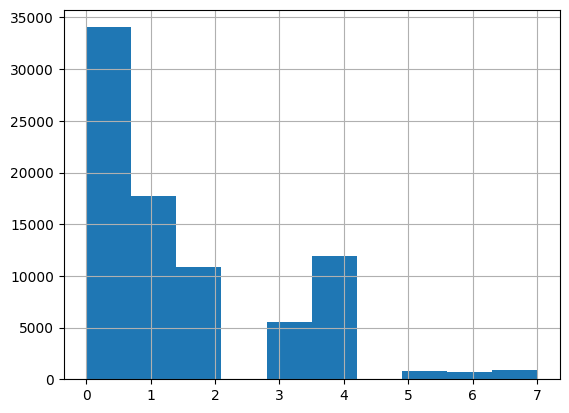

In [295]:
# Visualize the label distribution before filtering unwanted labels


scaled_data.label.hist()

<Axes: >

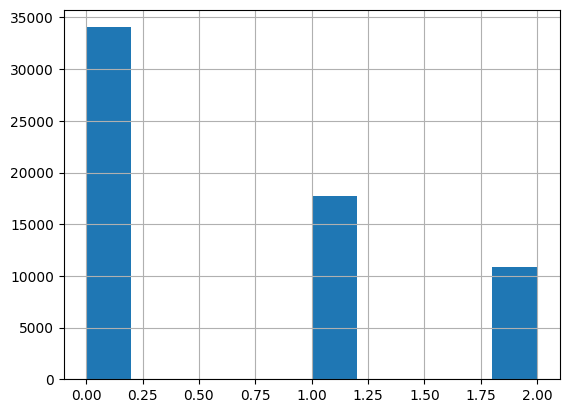

In [296]:
# Visualize the label distribution after filtering unwanted labels

scaled_data_.label.hist() 

In [297]:
# Due the label filtering, we need to update our list of subjects

subjects_col_ = scaled_data_.subject 
subjects_col_.shape

(62625,)

In [298]:
subjects_col_.values

array(['S10', 'S10', 'S10', ..., 'S9', 'S9', 'S9'], dtype=object)

In [333]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# model = SVC(kernel='rbf', C=10, gamma=0.001)
svm_model = SVC(kernel='rbf')
# model = SVC(kernel='rbf',  class_weight='balanced')

logo = LeaveOneGroupOut()

groups = subjects_col_
X = scaled_data_.drop(columns=['label', 'subject'])
y = scaled_data_.label 

svm_confusion_matrices = []
accuracies = []
f1_scores = []
subjects_ids = [] 

counter = 1

print(f"- len subjects_id : {len(subjects_col_)}")
print(f"- len subjects_id : {subjects_col_.shape}")
print(f"- len X : {len(X)}")
print(f"- len y : {len(y)}")

debug_counter = 0
debug_x_train_lst = []
debug_x_test_lst = []

print(f"- Start the training process")
for fold_idx, (train_index, test_index) in enumerate(logo.split(X, y, groups=groups), start=1):
    
    train_subjects = np.unique(groups.iloc[train_index])
    test_subjects = np.unique(groups.iloc[test_index])
    
    print(f"Fold {fold_idx}:")
    print(f"Subjects in training set: {train_subjects}")
    print(f"Subjects in testing set: {test_subjects}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    if debug_counter < 2 : 
        debug_x_train_lst.append(X_train)
        debug_x_test_lst.append(X_train)
    else : 
        break 
    
    debug_counter += 1 
    
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    
    print(f'y_pred: {y_pred}')
    print(f'y_true: {y_test.values}')
    
    if np.array_equal(y_pred, y_test.values) : 
        print(f'y_pred and y_test are equal')
    else : 
        print(f'y_pred and y_test have different values')
        

    cm = confusion_matrix(y_test, y_pred)
    svm_confusion_matrices.append(cm)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    f1 = f1_score(y_test, y_pred, average="weighted")
    f1_scores.append(f1)
    
    print(f"{fold_idx}- Accuracy: {accuracy}")
    print(f"{fold_idx}- f1-score: {f1}")
 

# Summary of results
accuracies = np.array(accuracies)
f1_scores = np.array(f1_scores)
print(f"The avg accuracy: {accuracies.mean()}")
print(f"The avg f1_scores: {f1_scores.mean()}")
print(f"The std accuracy: {accuracies.std()}")
print(f"The min accuracy: {accuracies.min()}")
print(f"The max accuracy: {accuracies.max()}")

- len subjects_id : 62625
- len subjects_id : (62625,)
- len X : 62625
- len y : 62625
- Start the training process
Fold 1:
Subjects in training set: ['S11' 'S13' 'S14' 'S15' 'S16' 'S17' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8'
 'S9']
Subjects in testing set: ['S10']
y_pred: [0 0 0 ... 0 0 0]
y_true: [0 0 0 ... 0 0 0]
y_pred and y_test have different values
1- Accuracy: 0.9992814371257485
1- f1-score: 0.9992816556919845
Fold 2:
Subjects in training set: ['S10' 'S13' 'S14' 'S15' 'S16' 'S17' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8'
 'S9']
Subjects in testing set: ['S11']
y_pred: [0 0 0 ... 0 0 0]
y_true: [0 0 0 ... 0 0 0]
y_pred and y_test have different values
2- Accuracy: 0.9992814371257485
2- f1-score: 0.9992816556919845
Fold 3:
Subjects in training set: ['S10' 'S11' 'S14' 'S15' 'S16' 'S17' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8'
 'S9']
Subjects in testing set: ['S13']
The avg accuracy: 0.9992814371257485
The avg f1_scores: 0.9992816556919845
The std accuracy: 0.0
The min accuracy: 0.9992814371257485


In [337]:
debug_x_train_lst[0]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
5496,0.850905,0.010953,1.485921,0.954256,-1.724485,1.721283,1.260471,1.488602,1.570395,1.747028,1.663341,-1.726284,1.711061,1.715939,1.704014,-1.748491,1.629252,-1.678784,-1.710384,1.482899
5497,1.504100,0.123268,-1.315866,-1.456362,-1.502268,-1.668124,1.501417,-0.570427,1.399391,1.531317,-0.157838,0.531937,1.128621,-1.330852,1.282167,-1.146979,-0.799377,-1.382263,0.769823,-0.204628
5498,-1.335808,0.011262,-0.346334,-1.432025,-1.543960,0.456899,-0.631399,-0.490387,1.476707,-0.664492,0.543825,0.332647,-1.140308,-0.739578,0.814226,0.566655,0.770143,0.460596,1.183944,-0.199314
5499,-1.325492,0.003511,-0.905263,-1.427346,-1.488602,0.369478,0.313307,-0.495154,1.294799,1.496017,0.524847,0.327645,-0.735655,0.378920,0.620521,-1.334862,1.262317,-1.168453,0.424387,-0.197657
5500,-1.067765,-0.001646,-1.213587,-1.418504,-1.485982,0.062257,1.110760,-0.869834,1.360275,0.843495,1.449573,0.338751,-1.277626,0.776229,0.694036,-0.522796,-0.637507,0.413079,0.070373,-0.195399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82435,0.217727,-0.116028,-0.948538,-1.382785,-1.630045,-0.228845,1.457332,-0.452878,1.194914,1.301463,1.373233,1.711642,1.366175,0.089888,0.866493,-0.481075,0.477264,-0.502926,0.954047,0.039551
82436,-1.138227,-0.129577,-0.854168,-1.376643,-1.578985,0.250920,1.363265,0.221628,0.873668,1.094050,1.209018,1.706501,0.730151,1.033438,0.809716,-1.299795,0.111757,0.403779,0.188676,-1.644992
82437,-1.144816,-0.186125,-0.993265,-1.369465,-1.692848,1.068951,1.194234,-0.926134,-1.313338,1.287287,1.551682,1.696250,1.577984,-0.897864,0.453767,-1.508124,1.485773,1.175619,0.320106,0.081827
82438,0.327109,0.267318,1.346266,0.923357,-1.736982,1.721283,1.422833,1.478716,-1.703705,1.749362,-1.689644,0.528528,1.714504,1.715484,1.706148,-1.740940,1.676132,-1.729292,-1.709000,0.383171


In [340]:
debug_x_train_lst[1].compare(debug_x_train_lst[0])

ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

In [331]:
np.True_ in X_test.isin(X_train).values

False

In [329]:

type(np.True_)

numpy.bool_

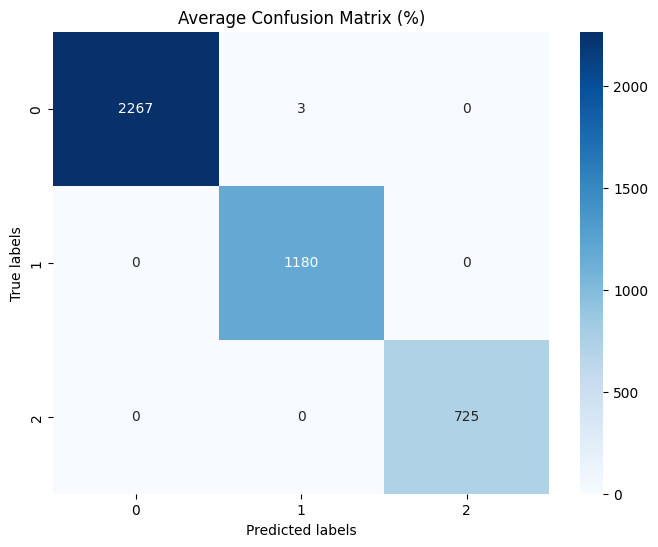

In [286]:
def compute_average_confusion_matrix(confusion_matrices):
    # Filter out matrices with different shapes
    base_shape = confusion_matrices[0].shape
    filtered_matrices = [cm for cm in confusion_matrices if cm.shape == base_shape]

    # Sum all matrices
    sum_matrix = np.sum(filtered_matrices, axis=0)
    
    # Compute the average
    avg_matrix = sum_matrix / len(filtered_matrices)
    
    return avg_matrix

def convert_to_percentage(matrix):
    percentage_matrix = matrix * 100
    return percentage_matrix

# Compute the average confusion matrix
average_confusion_matrix = compute_average_confusion_matrix(svm_confusion_matrices)
# average_confusion_matrix = convert_to_percentage(average_confusion_matrix)
# print("Average Confusion Matrix:\n", average_confusion_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(average_confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar = True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Average Confusion Matrix (%)')
plt.show()

In [278]:
pd.DataFrame(y_pred).value_counts()

0
0    2267
1    1183
2     725
Name: count, dtype: int64

In [279]:
pd.DataFrame(y_test.values).value_counts()


0
0    2270
1    1180
2     725
Name: count, dtype: int64

In [282]:
accuracy_score(y_true=y_test.values, y_pred=y_pred)

0.9992814371257485

In [257]:
scaled_data_[~(scaled_data_['subject'] == 'S10')]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,subject,label
5496,0.853105,0.012651,1.489081,0.953864,-1.723708,1.720377,1.235557,-0.891161,1.086305,1.567491,...,1.675003,-1.723208,1.720984,1.726840,1.722432,-1.714619,1.623066,-1.687345,S11,0
5497,1.528112,0.123703,-1.337160,-1.469635,-1.494501,-1.678898,1.485966,-1.117881,-1.121600,1.411223,...,1.440672,0.495835,1.238984,-1.394270,0.999108,-1.131750,-1.033156,-1.435330,S11,0
5498,-1.325465,0.012990,-0.318732,-1.442726,-1.535931,0.453179,-0.643473,0.108652,-0.171562,1.481568,...,0.669692,0.330969,-1.129572,-0.802848,0.699634,0.625958,0.936752,0.184525,S11,0
5499,-1.317711,0.006484,-0.904113,-1.436251,-1.480554,0.359441,0.336255,-0.168784,-0.401785,1.250191,...,1.259677,0.302286,-0.642512,0.203805,0.399975,-1.321663,1.144555,-1.199183,S11,0
5500,-1.059532,0.001987,-1.222857,-1.429670,-1.478843,0.064340,1.103460,-0.008694,-0.543472,1.328706,...,1.504421,0.315314,-1.259064,0.613497,0.450366,-0.527047,-0.794805,0.242092,S11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82435,0.214633,-0.124145,-0.941571,-1.391837,-1.634961,-0.179183,1.443569,0.494853,0.158594,1.259432,...,-1.507542,1.716224,1.267330,0.249962,1.449102,-0.397692,1.269160,-0.371075,S9,0
82436,-1.117094,-0.143962,-0.851108,-1.384949,-1.567241,0.262231,1.361477,1.572657,1.480097,0.153227,...,1.509409,1.685046,0.726726,0.867458,0.479498,-1.306685,-0.003561,0.309638,S9,0
82437,-1.122359,-0.183570,-0.992539,-1.377934,-1.687422,1.068249,1.191032,0.881602,0.229741,-1.313270,...,1.403594,1.702367,1.582731,-0.902182,0.755879,-1.496908,1.461590,1.405668,S9,0
82438,0.316475,0.272406,1.344151,0.917558,-1.737191,1.720267,1.403980,-1.340456,0.585384,-1.703979,...,-1.687310,0.507883,1.723552,1.726372,1.723802,-1.707705,1.670388,-1.736972,S9,0


In [258]:
scaled_data_[(scaled_data_['subject'] == 'S10')]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,subject,label
0,0.853105,0.012651,1.489081,0.953864,-1.723708,1.720377,1.235557,-0.891161,1.086305,1.567491,...,1.675003,-1.723208,1.720984,1.726840,1.722432,-1.714619,1.623066,-1.687345,S10,0
1,1.528112,0.123703,-1.337160,-1.469635,-1.494501,-1.678898,1.485966,-1.117881,-1.121600,1.411223,...,1.440672,0.495835,1.238984,-1.394270,0.999108,-1.131750,-1.033156,-1.435330,S10,0
2,-1.325465,0.012990,-0.318732,-1.442726,-1.535931,0.453179,-0.643473,0.108652,-0.171562,1.481568,...,0.669692,0.330969,-1.129572,-0.802848,0.699634,0.625958,0.936752,0.184525,S10,0
3,-1.317711,0.006484,-0.904113,-1.436251,-1.480554,0.359441,0.336255,-0.168784,-0.401785,1.250191,...,1.259677,0.302286,-0.642512,0.203805,0.399975,-1.321663,1.144555,-1.199183,S10,0
4,-1.059532,0.001987,-1.222857,-1.429670,-1.478843,0.064340,1.103460,-0.008694,-0.543472,1.328706,...,1.504421,0.315314,-1.259064,0.613497,0.450366,-0.527047,-0.794805,0.242092,S10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,0.214633,-0.124145,-0.941571,-1.391837,-1.634961,-0.179183,1.443569,0.494853,0.158594,1.259432,...,-1.507542,1.716224,1.267330,0.249962,1.449102,-0.397692,1.269160,-0.371075,S10,0
5492,-1.117094,-0.143962,-0.851108,-1.384949,-1.567241,0.262231,1.361477,1.572657,1.480097,0.153227,...,1.509409,1.685046,0.726726,0.867458,0.479498,-1.306685,-0.003561,0.309638,S10,0
5493,-1.122359,-0.183570,-0.992539,-1.377934,-1.687422,1.068249,1.191032,0.881602,0.229741,-1.313270,...,1.403594,1.702367,1.582731,-0.902182,0.755879,-1.496908,1.461590,1.405668,S10,0
5494,0.316475,0.272406,1.344151,0.917558,-1.737191,1.720267,1.403980,-1.340456,0.585384,-1.703979,...,-1.687310,0.507883,1.723552,1.726372,1.723802,-1.707705,1.670388,-1.736972,S10,0


In [260]:
scaled_data_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62625 entries, 0 to 82439
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PC1      62625 non-null  float64
 1   PC2      62625 non-null  float64
 2   PC3      62625 non-null  float64
 3   PC4      62625 non-null  float64
 4   PC5      62625 non-null  float64
 5   PC6      62625 non-null  float64
 6   PC7      62625 non-null  float64
 7   PC8      62625 non-null  float64
 8   PC9      62625 non-null  float64
 9   PC10     62625 non-null  float64
 10  PC11     62625 non-null  float64
 11  PC12     62625 non-null  float64
 12  PC13     62625 non-null  float64
 13  PC14     62625 non-null  float64
 14  PC15     62625 non-null  float64
 15  PC16     62625 non-null  float64
 16  PC17     62625 non-null  float64
 17  PC18     62625 non-null  float64
 18  PC19     62625 non-null  float64
 19  PC20     62625 non-null  float64
 20  subject  62625 non-null  object 
 21  label    62625 no

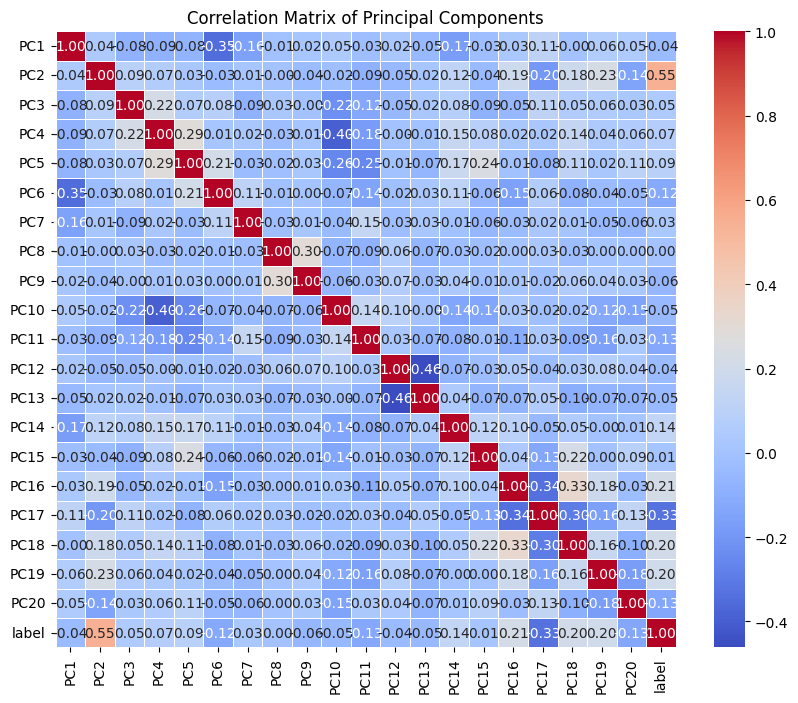

In [267]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'scaled_data_' is your DataFrame
# Calculate the correlation matrix
correlation_matrix = scaled_data_.drop(labels=['subject'], axis=1).corr()  # Exclude the last two columns 'subject' and 'label'

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Principal Components')
plt.show()
